### ECG - Synthetic Datasets and Encodings for Diffusion Models

In this notebook we will build and demonstrate the methods that help use with creating a synthetic dataset.

- Timeseries encoding
- Spectrograms
- Generate noisy samples
- Generate embedded data
- Additional datasets

In [1]:
import torch
import torchaudio 
import wfdb
import os
import sys
import wfdb
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.signal import resample
from wfdb import processing
from pyts.image import MarkovTransitionField

print('Virtual Environment:')
print(sys.prefix)


Virtual Environment:
c:\Users\Pie\Desktop\Thesis\code\signal-denoising\.venv


Auxiliary methods for visualization.

In [2]:
def plot_multiple_timeseries(signals, names):
    num_signals = len(signals)
    
    plt.figure(figsize=(5 * num_signals, 4))

    for i, (signal, name) in enumerate(zip(signals, names), 1):
        plt.subplot(1, num_signals, i)
        plt.plot(signal)
        plt.title(name)
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')

    plt.tight_layout()
    plt.show()

def visualize_tensor(tensor):
    print('Shape', tensor.shape)

    # Convert the tensor to a NumPy array
    image_array = tensor.numpy()

    # Transpose the array to (H, W, C) format
    image_array = image_array.transpose(1, 2, 0)

    # Display the image using Matplotlib
    plt.imshow(image_array)
    plt.axis('off')  # Turn off axis
    plt.show()

#### Encoding Timeseries for Deep Learning
We can use an alternative approach from this paper (https://arxiv.org/pdf/1506.00327.pdf) also used in a paper that used diffusion models to generate ECG signals (https://arxiv.org/pdf/2303.02475.pdf).

Further researched in this paper (https://www.researchgate.net/figure/Conceptual-block-diagram-of-the-proposed-structure-for-individual-household-power_fig4_338359485)

Not Investigated:
- recurrence plots

-------- 
TLDR: \
<font color='orange'>- Slow, images are large</font> \
<font color='lime'>- Normalized, (almost) loseless</font> 

In [4]:
# From paper 'Generating ECG using Diffusion Models' (2023)
def rescale_time_series(X):     
    """
    Rescale the time series X to fall within the interval [-1, 1].
    
    Parameters:
    X (array-like): The input time series.
    
    Returns:
    X_rescaled (array-like): The rescaled time series.
    """
    # Min-Max scaling: 
    # https://github.com/devitrylouis/imaging_time_series/blob/master/gramian_angular_field.py
    min_ = np.amin(X)
    max_ = np.amax(X)
    scaled_serie = (2*X - max_ - min_)/(max_ - min_)
    # Floating point inaccuracy!
    scaled_serie = np.where(scaled_serie >= 1., 1., scaled_serie)
    scaled_serie = np.where(scaled_serie <= -1., -1., scaled_serie)

    return scaled_serie

# Load the MTF once
mtf = MarkovTransitionField()

# Embedd 
def ecg_to_ggm(X):
    # Rescale
    X = rescale_time_series(X)

    # Calculate the radius values 'r' using the time stamps
    # r = np.arange(1, len(X) + 1) / len(X)

    # Calculate the angular values 'phi' using the rescaled time series
    phi = np.arccos(X)

    # Compute GASF matrix
    N = len(X)
    GASF = np.zeros((N, N))
    N = len(X)
    GADF = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            GASF[i, j] = np.cos((phi[i] + phi[j]) / 2)
            GADF[i, j] = np.cos((phi[i] - phi[j]) / 2)
    
    # Compute MTF matrix
    MTF = mtf.transform(X.reshape(1,-1))
    MTF = MTF[0]

    # Return Tensor (3,x,x) 'RGB'
    ggm = np.stack((GASF, GADF, MTF),axis=-1)
    x = torch.tensor(ggm)
    x = torch.permute(x, (2, 0, 1))

    return x  

# Reconstruct
def ggm_to_ecg(ggm):

    # Undo the permuation
    ggm_restored = torch.permute(ggm, (1, 2, 0))

    # Convetr to numpy
    ggm = ggm_restored.detach().cpu().numpy()

    # Debugging
    # print('Type of GGM', type(ggm))
    # print('Shape of GGM', ggm.shape)

    # Extract GASF channel
    gasf_channel = ggm[:, :, 0]
    
    # Extract diagonal elements
    diagonals = np.diagonal(gasf_channel)

    return diagonals

In [ ]:
###### Example ######
record_102 = wfdb.rdsamp("data/ardb/102", sampto=512)
x = record_102[0][:, 0]

# Convert to GGM and visualize
ggm_clean = ecg_to_ggm(x)
visualize_tensor(ggm_clean)

# Reconstruct from GGM
rec_sig  = ggm_to_ecg(ggm_clean)

# Visualize original and reconstructed signal
plot_multiple_timeseries([x,  rec_sig],['Original Signal', 'Recovered Signal'])

#### Spectrograms

Square tensors (spectrograms) are obtained by taking the right values for samples_to, n_fft and hop_length.

A bigger problem is the reconstruction part. We lose phase information, which means we will have to work with a lossy reconstruction. PytorchAudio has a Griffin Lim implementation we use for now. The probably best approach would be to use gradient ascent. Additional recources.

- https://pytorch.org/audio/stable/transforms.html
- https://reference.wolfram.com/language/ref/InverseSpectrogram.html
- https://de.mathworks.com/help/signal/ug/signal-recovery-with-differentiable-scalograms-and-spectrograms.html#SignalRecoveryWithDifferentiableSPExample-1 

Approach 1:

- Using lossy conversion with Griffin [PytorchAudio]

In [ ]:
def ecg_to_spectrogram_log(ecg_signal, n_fft=32, hop_length=4):
    """
    Convert ECG signal to spectrogram using torchaudio library.

    Args:
    - ecg_signal (torch.Tensor): 1D tensor representing the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Spectrogram of the ECG signal.
    """
    # Reshape ECG signal to (batch_size, num_channels, signal_length)
    ecg_signal = ecg_signal.unsqueeze(0).unsqueeze(0)

    # Compute spectrogram
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length)(ecg_signal)

    # Take the log
    spec = spectrogram[0]
    spec_log = torch.log10(spec)

    return spec_log

def spectrogram_log_to_ecg(spec_log, n_fft=32, hop_length=None,n_iter=400):
    """
    Convert spectrogram back to ECG signal using torchaudio library.

    Args:
    - spectrogram (torch.Tensor): Spectrogram of the ECG signal.
    - n_fft (int): Size of FFT window. Default is 400.
    - hop_length (int or None): Number of samples between successive frames.
      If None, defaults to n_fft / 4. Default is None.

    Returns:
    - torch.Tensor: Reconstructed ECG signal.
    """
    # Undo log operation
    spec = torch.pow(10, spec_log)

    # Compute inverse spectrogram
    ecg_signal = torchaudio.transforms.GriffinLim(n_fft=n_fft,  n_iter=400, hop_length=hop_length)(spec)

    # Squeeze the batch and channel dimensions
    ecg_signal = ecg_signal.squeeze(0).squeeze(0)

    return ecg_signal

######### Parameters ##########
samples_to = (62*16) + 16
n_fft = 126
hop_length = 16

# Load Data
path_102 = "data/ardb/104"
record_102 = wfdb.rdsamp(path_102, sampto=samples_to)
signal_102 = record_102[0][:, 0]
signal_102 = signal_102

# Build and Visualize Spectrogram
sig = torch.tensor(signal_102)
spek_log = ecg_to_spectrogram_log(sig,n_fft=n_fft, hop_length=hop_length)
visualize_tensor(spek_log)

# Visualize reoncstruction using Griffin...
reconstructed_sig = spectrogram_log_to_ecg(spek_log,n_fft,hop_length)
reconstructed_sig = -reconstructed_sig                                        # flip phase for whatever reason...
plot_multiple_timeseries([sig, reconstructed_sig], ['Original', 'Griffin Reconstruction', 'Griffin New'])

# Info
print('Number of samples:', samples_to)
print('Duration in seconds:', samples_to/360)
print('Shape of spectrogram:',spek_log.shape)


#### Generate Noisy Samples

Since our goal is to use a supervised learning (e.g. diffusion image restauration models). We need to build a training/test set.

In [6]:
# Extract record
# sampto=128*2*2            ## old settings
sampto=1008
record_bw = wfdb.rdsamp("data/nstdb/bw", sampto=sampto); signal_bw = record_bw[0][:, 0] 
record_em = wfdb.rdsamp("data/nstdb/em", sampto=sampto); signal_em = record_em[0][:, 0]
record_ma = wfdb.rdsamp("data/nstdb/ma", sampto=sampto); signal_ma = record_ma[0][:, 0]

signals = [signal_bw,signal_em,signal_ma]
names = ['Basline Wander', 'Electrode Motion', 'Muscle Artifact']

# Plot multiple time series
# plot_multiple_timeseries(signals,names)

# Plot multiple 2D Embeddings
# visualize_tensor(ecg_to_ggm(signal_bw)); visualize_tensor(ecg_to_ggm(signal_em)); visualize_tensor( ecg_to_ggm(signal_ma))

We can linearly add noise to the samples and control the $SNR$. We use the strategy used in this paper: https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9779754. We do not investigate gaussian noise at this this point.

In [7]:
def add_noise(ecg_signal, noise_signal, snr_dB):
    """
    Add noise to the clean ECG signal.

    Parameters:
    - ecg_signal (ndarray): The clean ECG signal.
    - noise_signal (ndarray): The noise signal to be added.
    - snr_dB (float): The desired signal-to-noise ratio in decibels.

    Returns:
    - noisy_signal (ndarray): The noisy ECG signal.
    """
    # Calculate lambda (λ) based on the desired SNR
    lambda_value = np.sqrt(np.mean(ecg_signal**2)) / (np.sqrt(np.mean(noise_signal**2)) * 10**(0.1 * snr_dB / 2))

    # Generate noisy signal
    noisy_signal = ecg_signal + (noise_signal * lambda_value)

    return noisy_signal

Time for an example and some visualizations!

In [ ]:
# Define clean ECG signal
# sampto=128*2*4
record = wfdb.rdsamp("data/ardb/102", sampto=sampto)
ecg_signal = record[0][:, 0] 

# Define noise signal
path_to_noise = "data/nstdb/bw"
record_noise = wfdb.rdsamp(path_to_noise, sampto=sampto)
noise_signal = record_noise[0][:, 0] 
noise_type = path_to_noise[-2:]

# Desired signal-to-noise ratio (SNR) in decibels
snr_dB = 5  # Example SNR       

# Add noise to the clean ECG signal
noisy_signal = add_noise(ecg_signal, noise_signal, snr_dB)

# Different Visualizations...
signals=[ecg_signal, noise_signal,  noisy_signal] 
names=["Original Signal", "Noise "+str(noise_type), "Noisy Signal SNR "+str(snr_dB)]

# Time Series
plot_multiple_timeseries(signals,names)

#### Generate Embedded Data
One paper that works with 1D CCNs uses a 3.0 sec sliding window : https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9779754. I do assume however, if we want to work with 2D CNNs, we will loose too much detail (does not have to be I guess...).

An altenative approach of researchers that used diffusion models to generate synthetic hearbeats, was to 'split up' the signal into segmeents with just individual heartbeats (https://arxiv.org/pdf/2306.01875.pdf). They did this based on 270 samples, which corresponds to 0.75 seconds, given a sampling rate of 360. However, since certain noise types can clearly affect multiple heartbeats so we might have to find a middle ground. 

One approach using samples of 540 samples and keeps the  'hearbeats' intact/ important characteristics. We then crop 512 samples, because this allows us to work with U-Net without need for further modificaiton (trade-off). We uses 512 samples when working with GGM embedding. For now, trial-and-error showed us that 1008 samples is handy when working with spectrograms, if we want to obtain tensors with size (1,64,64).

-----
TLDR: 
- <font color='orange'>GGM Encoding, Length 512 samples, AM and EM noise, SNR=5</font>  (too slow on local CPU)
- <font color='cyan'>Spectrogram, Length 504 samples, AM and EM noise, SNR=5</font>  (might not work with Matlab...)

In [ ]:
#### original length signal ####
record = wfdb.rdsamp("data/ardb/104")
x = record[0][:, 0]

print('Total length of sample',len(x))
print('Total duration of sample',len(x)/360)

# Define the length of a cardiac cycle (taken from paper)
cycle_length = 270

# Split the ECG signal into cardiac cycles
cardiac_cycles = []
for i in range(0, len(ecg_signal), cycle_length):
    cycle = ecg_signal[i:i+cycle_length]
    cardiac_cycles.append(cycle)

Our sample length is $650000$ and based on paper we took $270$ as an 'average' duration for an individual heartbeat.

In [9]:
# Read the ECG signal from the record
record = wfdb.rdsamp("data/ardb/104")
ecg_signal = record[0][:, 0]

def slice_ecg_signal(ecg_signal, signal_length, heartbeat_duration, k):
    k_heartbeats = heartbeat_duration * k
    parts_of_interest = signal_length // k_heartbeats
    return [ecg_signal[i * k_heartbeats : (i + 1) * k_heartbeats] for i in range(parts_of_interest)]

If we define our length/ number of heartbeats, we can slice the indivual records to obtain many smaller signals/slices. 

In [10]:
# Define Variables
signal_length = 650000
heartbeat_duration = 270
k = 2  ## spectrogram

# Function to read ECG signals from .dat files and generate slices
def generate_slices(folder_path):
    # Initialize an empty dictionary to store slices
    slices_dict = {}

    # Loop through all files in the folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.dat'):
            # Extract the record number from the file name
            record_number = file_name.split('.')[0]

            # Read the ECG signal from the .dat file
            record = wfdb.rdsamp(os.path.join(folder_path, record_number))
            ecg_signal = record[0][:, 0]

            # Generate slices
            slices = slice_ecg_signal(ecg_signal,signal_length,heartbeat_duration,k)

            # Add slices to the dictionary
            slices_dict[record_number] = slices

    return slices_dict

# Folder path containing the .dat files
folder_path = "data/ardb"

#  Noisebaselinewander.
record_bw = wfdb.rdsamp("data/nstdb/bw")
noise_bw = record_bw[0][:, 0]

# Generate slices and create dictionary
slices_dict_clean = generate_slices(folder_path)

# Print the dictionary
for record_number, slices in slices_dict_clean.items():
    print(f"Record Number: {record_number}, Number of Slices: {len(slices)}")

Record Number: 100, Number of Slices: 1203
Record Number: 101, Number of Slices: 1203
Record Number: 102, Number of Slices: 1203
Record Number: 103, Number of Slices: 1203
Record Number: 104, Number of Slices: 1203
Record Number: 105, Number of Slices: 1203
Record Number: 106, Number of Slices: 1203
Record Number: 107, Number of Slices: 1203
Record Number: 108, Number of Slices: 1203
Record Number: 109, Number of Slices: 1203
Record Number: 111, Number of Slices: 1203
Record Number: 112, Number of Slices: 1203
Record Number: 113, Number of Slices: 1203
Record Number: 114, Number of Slices: 1203
Record Number: 115, Number of Slices: 1203
Record Number: 116, Number of Slices: 1203
Record Number: 117, Number of Slices: 1203
Record Number: 118, Number of Slices: 1203
Record Number: 119, Number of Slices: 1203
Record Number: 121, Number of Slices: 1203
Record Number: 122, Number of Slices: 1203
Record Number: 123, Number of Slices: 1203
Record Number: 124, Number of Slices: 1203
Record Numb

Since we want to build a synthetic dataset (known ground truth), we need both clean- and noisy signals. We can build a new dictionary, that contains the samples, however with noise added. We add the different types of noise at specific SNRs.
- (baseline wander at SNR=5)        * skipped for now.. cause the other ones are harder to remove..
- electrode motion at SNR=5
- muscle artificats at SNR=5

In [11]:
# Duration of slice
slice_duration = 2*270

# Noise
record_bw = wfdb.rdsamp("data/nstdb/bw", sampto=slice_duration)
noise_bw = record_bw[0][:, 0]

record_em = wfdb.rdsamp("data/nstdb/em", sampto=slice_duration)
noise_em = record_em[0][:, 0]

record_ma = wfdb.rdsamp("data/nstdb/ma", sampto=slice_duration)
noise_ma = record_ma[0][:,0]

# Signal-to-noise ratio
snr = 5

# Build the dictionary with noisy samples
def generate_noisy_samples(slices_dict, noise_sample, snr_dB):
    noisy_samples_dict = {}
    
    # Initialize tqdm to display progress
    pbar = tqdm(total=len(slices_dict), desc="Generating Noisy Samples")
    
    for record_number, slices in slices_dict.items():
        noisy_slices = []
        for slice in slices:
            noisy_slice = add_noise(slice, noise_sample, snr_dB)
            noisy_slices.append(noisy_slice)
        
        # Update the progress bar
        pbar.update(1)
        
        noisy_samples_dict[record_number] = noisy_slices
    
    # Close the progress bar
    pbar.close()
    
    return noisy_samples_dict

slices_dict_noisy_bw_SNR_5 = generate_noisy_samples(slices_dict_clean, noise_bw, snr)  # Since this can be filtered... we focus on the challenging noise types first
slices_dict_noisy_em_SNR_5 = generate_noisy_samples(slices_dict_clean, noise_em, snr)
slices_dict_noisy_ma_SNR_5 = generate_noisy_samples(slices_dict_clean, noise_ma, snr)

mixed_noise = noise_bw + noise_em + noise_em
slices_dict_noisy_mixed_SNR_5 = generate_noisy_samples(slices_dict_clean,mixed_noise,snr)


Generating Noisy Samples:   0%|          | 0/48 [00:00<?, ?it/s]

Generating Noisy Samples: 100%|██████████| 48/48 [00:02<00:00, 19.94it/s]


Since we will work with Pytorch (and Tensorflow) we will convert our dictionaries and then use the library focused structure. By sorting them, we know they correspond to the same original slice.

In [ ]:
# Dictionaries to list
clean_slices_list = [slices_dict_clean[key] for key in sorted(slices_dict_clean.keys())]

noisy_slices_bw_SNR_5_list = [slices_dict_noisy_bw_SNR_5[key] for key in sorted(slices_dict_noisy_bw_SNR_5.keys())]
noisy_slices_em_SNR_5_list = [slices_dict_noisy_em_SNR_5[key] for key in sorted(slices_dict_noisy_em_SNR_5.keys())]
noisy_slices_ma_SNR_5_list = [slices_dict_noisy_ma_SNR_5[key] for key in sorted(slices_dict_noisy_ma_SNR_5.keys())]
noisy_slices_mixed_SNR_5_list = [slices_dict_noisy_mixed_SNR_5[key] for key in sorted(slices_dict_noisy_mixed_SNR_5.keys())]

# Flatten
clean_slices_flat = [slice for sublist in clean_slices_list for slice in sublist]

noisy_slices_bw_SNR_5_flat = [slice for sublist in noisy_slices_bw_SNR_5_list for slice in sublist]
noisy_slices_em_SNR_5_flat = [slice for sublist in noisy_slices_em_SNR_5_list for slice in sublist]
noisy_slices_ma_SNR_5_flat = [slice for sublist in noisy_slices_ma_SNR_5_list for slice in sublist]
noisy_slices_mixed_SNR_5_flat = [slice for sublist in noisy_slices_mixed_SNR_5_list for slice in sublist]

print('Number of noisy samples... mixed noise', len(noisy_slices_mixed_SNR_5_flat))
print('Number of clean slices', len(clean_slices_flat))

plot_multiple_timeseries([clean_slices_flat[1000],noisy_slices_mixed_SNR_5_flat[1000]],['Clean', 'Mixed Noise Added'])

Let us build training data based from **ardb** database. Let's start with one noise type (electrode motition). We can easily augment with data from other sets. 

In [15]:
import pickle

# Display Info
num_of_slices = len(clean_slices_flat);   print('Number of slices',num_of_slices)
len_of_slice = len(clean_slices_flat[0]); print('Length of slice', len_of_slice)

# Spectrograms
specs_clean = []
specs_noisy_EM_snr_5 = []
# speks_noisy_MA_snr_5 = []

# Spectrogram Parameters
n_fft = 126
hop_length = 8
sampto = (62*8) + 8 

# Build Spectrograms
for i in tqdm(range(num_of_slices)):

    #######
    ecg_clean =  torch.tensor(clean_slices_flat[i][:sampto])
    ecg_noisy_EM = torch.tensor(noisy_slices_em_SNR_5_flat[i][:sampto])
    
    #######
    spec_clean = ecg_to_spectrogram_log(ecg_clean, n_fft, hop_length)
    spec_noisy_EM = ecg_to_spectrogram_log(ecg_noisy_EM, n_fft, hop_length)

    #######
    specs_clean.append(spec_clean)
    specs_noisy_EM_snr_5.append(spec_noisy_EM)

# Save spectrograms as pickle files
with open('specs_clean.pkl', 'wb') as f:
    pickle.dump(specs_clean, f)

with open('specs_noisy_EM_snr_5.pkl', 'wb') as f:
    pickle.dump(specs_noisy_EM_snr_5, f)

Number of slices 57744
Length of slice 540


100%|██████████| 57744/57744 [01:22<00:00, 699.10it/s]


We need methods so we can easily work with PyTorch models. Especially, our SR3 model in Pytorch. We take the following steps:

1. Load the clean and noisy spectrogram from a pickle file.
2. Normalize both between [-1,1] and save as pickle file.
3. Build train/test set according to format to use with our diffusion model.

In [8]:
## Load from pickle

# Load specs_clean from pickle
# with open('specs_clean.pkl', 'rb') as f:
#     specs_clean = pickle.load(f)

# Load specs_noisy_EM_snr_5 from pickle
with open('specs_noisy_EM_snr_5.pkl', 'rb') as f:
    specs_noisy = pickle.load(f)

In [10]:
## Normalization Methods

def normalize_tensor(input_tensor):
    min_val = torch.min(input_tensor)
    max_val = torch.max(input_tensor)

    # Normalize the tensor between -1 and 1
    normalized_tensor = 2 * ((input_tensor - min_val) / (max_val - min_val)) - 1

    return normalized_tensor

def undo_normalization_tensor(normalized_tensor):
    min_val = -1
    max_val = 1

    # Undo normalization
    original_tensor = ((normalized_tensor + 1) / 2) * (max_val - min_val) + min_val

    return original_tensor

In [19]:
## Normalize the data...[-1,1] 

specs_clean_normalized = []


# CLEAN
for i in tqdm(range(len(specs_clean))):
    input_tensor_clean = specs_clean[i]
    #################
    norm_spec_clean = normalize_tensor(input_tensor_clean)
    #################
    specs_clean_normalized.append(norm_spec_clean)

with open("specs_clean_normalized.pkl", 'wb') as file:
    pickle.dump(specs_clean_normalized, file)


  0%|          | 0/57744 [00:00<?, ?it/s]

  5%|▍         | 2633/57744 [00:00<00:08, 6421.93it/s]


KeyboardInterrupt: 

In [14]:
# NOISY
specs_noisy_normalized = []
for i in tqdm(range(len(specs_noisy))):
    input_tensor_noisy = specs_noisy[i]
    #################
    norm_spec_noisy = normalize_tensor(input_tensor_noisy)
    #################
    specs_noisy_normalized.append(norm_spec_noisy)


# TODO:
# Save specs_noisy_normalized as a pickle file
with open('specs_noisy_normalized.pkl', 'wb') as f:
    pickle.dump(specs_noisy_normalized, f)

  0%|          | 0/57744 [00:00<?, ?it/s]

100%|██████████| 57744/57744 [00:09<00:00, 6355.16it/s]


Ignore previous code... In case you just 

In [5]:
# Load specs_clean from pickle
with open('specs_clean_normalized.pickle', 'rb') as f:
    specs_clean = pickle.load(f)



In [15]:
# Load specs_noisy from pickle
with open('specs_noisy_normalized.pkl', 'rb') as f:
    specs_noisy = pickle.load(f)

In [17]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

## Assigned normalized list of tensors
# specs_clean = specs_clean_normalized
specs_noisy = specs_noisy_normalized

print(type(specs_clean[0]))

# # Define a custom PyTorch dataset 
class SpectrogramDataset(Dataset):
    def __init__(self, specs_clean, specs_noisy, transform=None):
        self.specs_clean = specs_clean
        self.specs_noisy = specs_noisy
        self.transform = transform

    def __len__(self):
        return len(self.specs_clean)

    def __getitem__(self, idx):
        spec_clean = self.specs_clean[idx]
        spec_noisy = self.specs_noisy[idx]

        if self.transform:
            spec_clean = self.transform(spec_clean)
            spec_noisy = self.transform(spec_noisy)

        return spec_clean, spec_noisy

# Split the data into training and validation sets
specs_clean_train, specs_clean_val, specs_noisy_train, specs_noisy_val = train_test_split(
    specs_clean, specs_noisy, test_size=0.2, random_state=42)

# Create datasets for training and validation
train_dataset = SpectrogramDataset(specs_clean_train, specs_noisy_train)
val_dataset = SpectrogramDataset(specs_clean_val, specs_noisy_val)

# Adapt to SR3 format
x_in_train = {'HR': specs_clean_train, 'SR': specs_noisy_train}
x_in_test = {'HR': specs_clean_val, 'SR': specs_noisy_val}


print(len(specs_clean_train))
print(type(specs_clean_train))
print(type(specs_clean_train[0]))

# # ***********************
# # Obtain some infromation
# Display some information about the data
print("Training Set:")
print("Number of samples:", len(specs_clean_train))
print("Shape of spectrograms (clean):", specs_clean_train[0].shape)
print("Shape of spectrograms (noisy):", specs_noisy_train[0].shape)
print()

print("Validation Set:")
print("Number of samples:", len(specs_clean_val))
print("Shape of spectrograms (clean):", specs_clean_val[0].shape)
print("Shape of spectrograms (noisy):", specs_noisy_val[0].shape)
print()

# print('Shape Training Dataset', train_dataset)

# # ***********************



<class 'torch.Tensor'>
46195
<class 'list'>
<class 'torch.Tensor'>
Training Set:
Number of samples: 46195
Shape of spectrograms (clean): torch.Size([1, 64, 64])
Shape of spectrograms (noisy): torch.Size([1, 64, 64])

Validation Set:
Number of samples: 11549
Shape of spectrograms (clean): torch.Size([1, 64, 64])
Shape of spectrograms (noisy): torch.Size([1, 64, 64])



#### Load the model here...

Diffusion model sauce time...

In [10]:
from src.generative_models import unet_SR3 as UNet
from src.generative_models import diffusion as diffusion

# Define parameters of the U-Net (denoising function)
in_channels = 2             # Gray , 2x 'concat' input
out_channels = 1            # one image...
inner_channels = 32         # Depth feature maps, model complexity 
norm_groups = 32            # Granularity of normalization, impacting convergence
channel_mults = (1, 2, 4, 8, 8)
attn_res = [8]
res_blocks = 3
dropout = 0
with_noise_level_emb = True
image_size = 16

# Instantiate the UNet model
denoise_fn = UNet(
    in_channel=in_channels,
    out_channel=out_channels,
    inner_channel=inner_channels,
    norm_groups=norm_groups,
    channel_mults=channel_mults,
    attn_res=attn_res,
    res_blocks=res_blocks,
    dropout=dropout,
    with_noise_level_emb=with_noise_level_emb,
    image_size=image_size
)

TypeError: 'module' object is not callable

We can also use our GGM encoding. However, running this on local CPU seems to slow. We can later try this on cloud CPU.

In [30]:
# Build GGM ... 
# --> NOTE: too demanding on local CPU!
ggm_emebeddings = []
num_iterations = 100

for i in tqdm(range(num_iterations)):
    ecg_noisy = noisy_slices_em_SNR_5_flat[i][:512]
    ggm = ecg_to_ggm(ecg_noisy)
    ggm_emebeddings.append(ggm)

# Save ggm embeddings as pickle files
with open('specs_clean.pkl', 'wb') as f:
    pickle.dump(specs_clean, f)    


  7%|▋         | 7/100 [00:08<01:54,  1.23s/it]


KeyboardInterrupt: 

#### Additional Datasets

Assume we want to obtain a bigger dataset. We can additionaly also process the (filtered) data in the ECG-ID dataset: https://physionet.org/content/ecgiddb/1.0.0/ . As said, these samples are cleaned. We can potentially use these or use the non-cleaned as a real dataset, if we don't use the filtered/clean signals for our training/validate/test sets.

Sampling rate: 500
Number of samples 10000
Duration in seconds 20.0


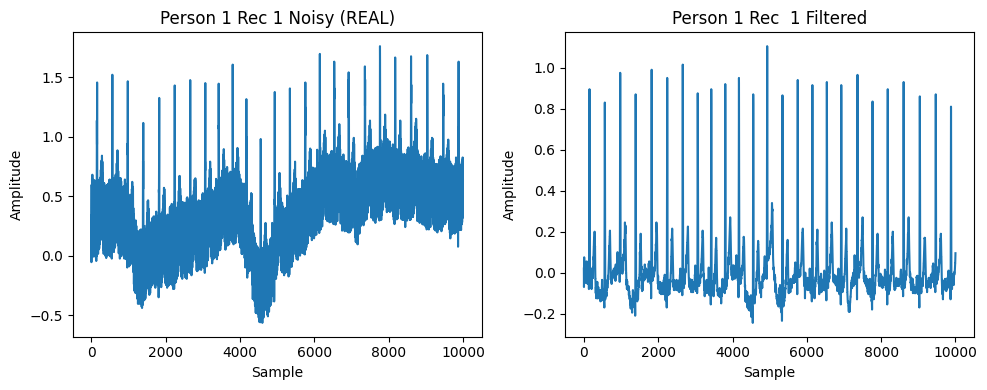

In [23]:
### Example: ECG-ID Dataset ###
record_id_p1_rec_1 = wfdb.rdsamp("data/ecg-id/Person_03/rec_1") 
signal_id_p1_rec_1_noisy = record_id_p1_rec_1[0][:, 0]
signal_id_p1_rec_1_filtered = record_id_p1_rec_1[0][:, 1]

# Obtain sampling rate and compute duration in seconds
num_of_samples = len(signal_id_p1_rec_1_filtered)
sampling_rate = record_id_p1_rec_1[1]['fs']
duration_in_seconds= num_of_samples/sampling_rate

# Display info
print("Sampling rate:", sampling_rate)
print('Number of samples', len(signal_id_p1_rec_1_filtered))
print('Duration in seconds', duration_in_seconds)

# Visualize
plot_multiple_timeseries([signal_id_p1_rec_1_noisy, signal_id_p1_rec_1_filtered], ['Person 1 Rec 1 Noisy (REAL)', 'Person 1 Rec  1 Filtered'])            # Nice...

We can use an alternative dataset, which might be of better quality. This is the PTB-XL dataset: https://physionet.org/content/ptb-xl/1.0.3/. We downloaded this dataset on Keggle via this link: https://www.kaggle.com/datasets/bjoernjostein/ptbxl-electrocardiography-database.

Length of HR1 5000
Length of HR1 Resample Scipy 3600


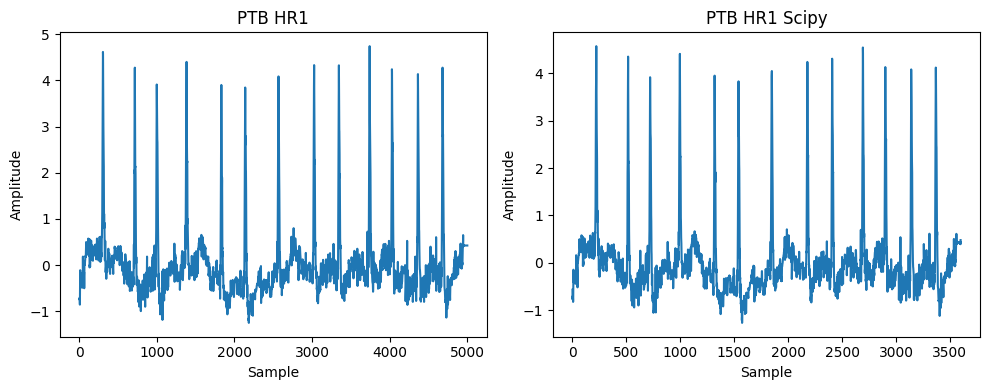

In [16]:
### Example: PTB-XL Dataset ###
record_ptb_HR1 = wfdb.rdsamp("data/PTB-XL/HR10323")
signal_ptb_HR1 =  record_ptb_HR1[0][:, 0]

# Original sampling rate
original_sampling_rate = 500  # Hz

# Target sampling rate
target_sampling_rate = 360  # Hz

# Resample the signal
num_samples_target = int(len(signal_ptb_HR1) * target_sampling_rate / original_sampling_rate)
resampled_signal_ptb_HR1 = resample(signal_ptb_HR1, num_samples_target)

print('Length of HR1', len(signal_ptb_HR1))
print('Length of HR1 Resample Scipy', len(resampled_signal_ptb_HR1))

plot_multiple_timeseries([signal_ptb_HR1, resampled_signal_ptb_HR1], ['PTB HR1','PTB HR1 Scipy'])

Let us first investigate the model for 57k samples... See how long the training takes. In the meanwhile we continue to generate more training data from the other datasets.